# Data Acquisition

## Initialization

Import standard scraping/processing packages:

In [2]:
import numpy as np
import pandas as pd
import dill
import requests
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import networkx as nx
import tqdm
import os

from itertools import combinations
from requests_futures.sessions import FuturesSession

matplotlib.rcParams['figure.dpi'] = 144
%matplotlib inline
sns.set()

Sensitive information is stored in the user-defined private_data.

In [3]:
from private_data import API_keys

secret_keys=API_keys()

## Power Station Meta Data

The power demand for MAXWEL comes from the Energy Information Agency (EIA) API. The EIA houses data for about NUMBER HERE power stations, substations, and  regional conglomerates.  I have selected 50
stations to model.

In [4]:
station_metadata_df=pd.read_csv("Data/Metadata/station_meta_data.csv")
station_metadata_df[['station_tag','city','longitude','latitude','timezone']].head()

,station_tag,city,longitude,latitude,timezone
0,CPLW,"Charlotte, NC",-80.843127,35.227087,America/New_York
1,NYIS,"Rensselaer, NY",-73.510773,42.709139,America/New_York
2,GCPD,"Moses Lake, WA",-119.278077,47.130142,America/Los_Angeles
3,LGEE,"Louisville, KY",-85.759407,38.254238,America/Kentucky/Louisville
4,TVA,"Belfast, TN",-86.702498,35.420907,America/Chicago


This generates a map of the stations being modeled, note the stations are spread across the country.

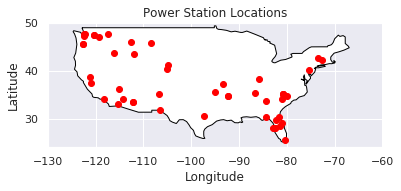

In [5]:
station_metadata_gdf = gpd.GeoDataFrame(
    station_metadata_df, 
    geometry=gpd.points_from_xy(station_metadata_df.longitude,
                                station_metadata_df.latitude))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world[world.name == 'United States of America'].plot(
    color='white', edgecolor='black')

station_metadata_gdf.plot(ax=ax, color='red')

plt.xlim([-130,-60])
plt.ylim([24,50])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Power Station Locations');

This dataframe also contains interchange connections, that is, which powerstations will exchange power when necessary.

In [6]:
station_metadata_df[['station_tag']+[f'interchange_{i}' for i in range(1,16)]].head()

,station_tag,interchange_1,interchange_2,interchange_3,interchange_4,interchange_5,interchange_6,interchange_7,interchange_8,interchange_9,interchange_10,interchange_11,interchange_12,interchange_13,interchange_14,interchange_15
0,CPLW,TVA,DUK,PJM,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null
1,NYIS,ISNE,PJM,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null
2,GCPD,AVA,BPAT,PACW,PSEI,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null
3,LGEE,TVA,MISO,Null,PJM,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null
4,TVA,AECI,CPLW,DUK,LGEE,MISO,PJM,SOCO,Null,Null,Null,Null,Null,Null,Null,Null


Generate and display the interchange graph, plotted using each stations coordinates.

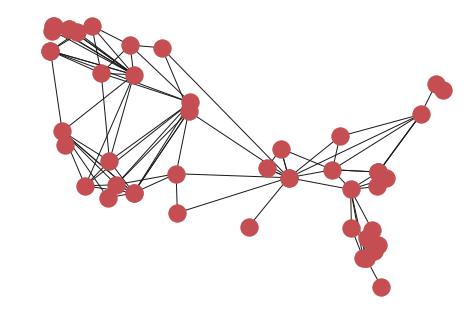

In [7]:
G=nx.Graph()
pos={}
for i in station_metadata_df.index:
    name=station_metadata_df['station_tag'].loc[i]
    pos[name]=(station_metadata_df['longitude'].loc[i],
               station_metadata_df['latitude'].loc[i])
    
    
    for j in range(1,16):
        temp=station_metadata_df[f'interchange_{j}'].loc[i]
        if temp!='Null':
            if not G.has_edge(name,temp):
                G.add_edge(name,temp)
nx.draw(G, with_labels=False,pos=pos)

##  Power Demand Data

The request reponses are timecoded using the ISO date standard, and contain the consumer demand, the day-ahead forecasted demand, and the net generation.

In [ ]:
start_date='1/1/2018'
end_date='7/29/2019'

idx=pd.date_range(start=start_date, end=end_date,freq='H')

names=dill.load(open('Jar/station_tags.pkl','rb'))

pull_keys=['D','DF','NG']

base_url="https://api.eia.gov/series/?"

Pull the data we want from the EIA API and save it to a dataframe.

In [ ]:
demand_pull_dict={}

for name in tqdm.tqdm_notebook(names):
    for key in pull_keys:
        pull=requests.get(base_url,
                          params={'api_key':secret_keys._EIA,
                                  'series_id':f'EBA.{name}-ALL.{key}.H'
                                  }).json()
        
        temp_array=np.asarray(pull['series'][0]['data'])
        temp_time=temp_array[:,0]
        temp_time=np.asarray(list(map(lambda x:
                                 datetime.datetime.strptime(x, "%Y%m%dT%HZ"), 
                                 list(temp_time))))
        
        demand_pull_dict[f'{name}_{key}']=pd.Series(temp_array[:,1],
                                                    index=temp_time
                                                    ).reindex(
                                                    idx,
                                                    fill_value=0) 

EIA_demand_df=pd.concat([demand_pull_dict[key].rename(key) 
                     for key 
                     in demand_pull_dict],axis=1)
EIA_demand_df.to_csv('Data/Demand_Data/Raw_Data/EIA_demand_data.csv')

## Weather Data

The weather data I'm collecting comes from the Dark Sky API, which allows 1000 free calls everyday.  I keep track of 44 cities (as some stations I'm modeling are in the same city) so I extract about 20 days of weather data with the following functions.

In [3]:
station_metadata_df=pd.read_csv("Data/Metadata/station_meta_data.csv")

def pull_all_from_date(time):
    """Saves weather data for the tracked cities for the input day"""
    # Convert to string
    time_string=time.strftime("%Y-%m-%d")
     
    # Try to make a new directory for the data
    new_dir=f'./Data/Weather_Data/Raw_Data/{time_string}'
    try:
        os.makedirs(new_dir)
    except:
        print('Overwriting existing directory')
    
    # Setup variables
    city_names=list(map(lambda x:x.split(',')[0],station_metadata_df['city'].unique()))
    timestamp=int(datetime.datetime.timestamp(time))
    city_to_coords=station_metadata_df[['city','latitude','longitude']].set_index('city').drop_duplicates().to_dict('index')
    
    # Spin up a futures session
    session = FuturesSession(max_workers=10)
    DS_url='https://api.darksky.net/forecast'
    responses={
        key: session.get(
             f'{DS_url}/{secret_keys._DS}/{city_to_coords[key]["latitude"]},{city_to_coords[key]["longitude"]},{timestamp}?',
             params={'extend':'hourly'}) 
        for key in city_to_coords.keys()}
    
    # Process and output the API responses
    for key in responses.keys():
        city=key.split(',')[0]
        try:
            data_dict=responses[key].result().json()['hourly']['data']
            df=pd.DataFrame(data_dict)
            df['location']=city
            df['time']=pd.to_datetime(df['time'],unit='s')
            df.to_csv(f'{new_dir}/{city}.csv')
        except:
            raise Exception('Dark Sky call limit exceeded.')
        
def daily_pull():
    """Iterates the pull_all_from_date function over next 20 dates to save"""
    
    # The dates which have already been saved are saved in /Jar
    pulled_dates=dill.load(open('Jar/pulled_dates.pkl', 'rb'))
    
    # The final date
    date=max(pulled_dates)

    # Pull and save the next 20 days
    for _ in tqdm.tqdm_notebook(range(20)):
        date+=datetime.timedelta(days=1)
        pull_all_from_date(date)
        pulled_dates.append(date)
        
    # Update the pulled dates pkl
    dill.dump(pulled_dates, open('Jar/pulled_dates.pkl', 'wb'))

Call the below to add 20 days of weather data to the 
Weather_Data/Raw_Data directory. 

N.B.
With the Dark Sky rate limit, this can only be called once a day!

In [4]:
daily_pull()

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

In [5]:
pulled_dates=dill.load(open('Jar/pulled_dates.pkl', 'rb'))
max(pulled_dates)

datetime.datetime(2019, 8, 20, 0, 0)